# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing Libraries and Data
#### 2. Subsetting, Wrangling, and Cleaning Time-Series Sata
#### 3. Time Series Analysis: Decomposition
#### 4. Testing for Stationarity
#### 5. Stationarizing the Data

### 1. Importing Libraries and Data

I used 'Airbnb Demand Data' from 2015 to 2020: https://www.kaggle.com/datasets/sukanyabag/airbnb-nyc-data/data?select=nyc_data.csv

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight') 

In [161]:
df = pd.read_csv('/Users/selcenayranci/Desktop/NYC airbnb demand 2015-2020.csv', sep=';')

In [119]:
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [126]:
df.shape

(2192, 7)

In [127]:
df.columns

Index(['Date', 'Demand', 'Easter', 'Thanksgiving', 'Christmas', 'Temperature',
       'Marketing'],
      dtype='object')

In [187]:
df_sub = df[['Date', 'Demand']]
df_sub.head()

,Date,Demand
0,1/1/2015,720.000885
1,1/2/2015,581.276773
2,1/3/2015,754.117039
3,1/4/2015,622.252774
4,1/5/2015,785.373319


### 2. Subsetting, Wrangling, and Cleaning Time-Series Sata

In [188]:
# Setting the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,Demand
datetime,
2015-01-01,720.000885
2015-01-02,581.276773
2015-01-03,754.117039
2015-01-04,622.252774
2015-01-05,785.373319


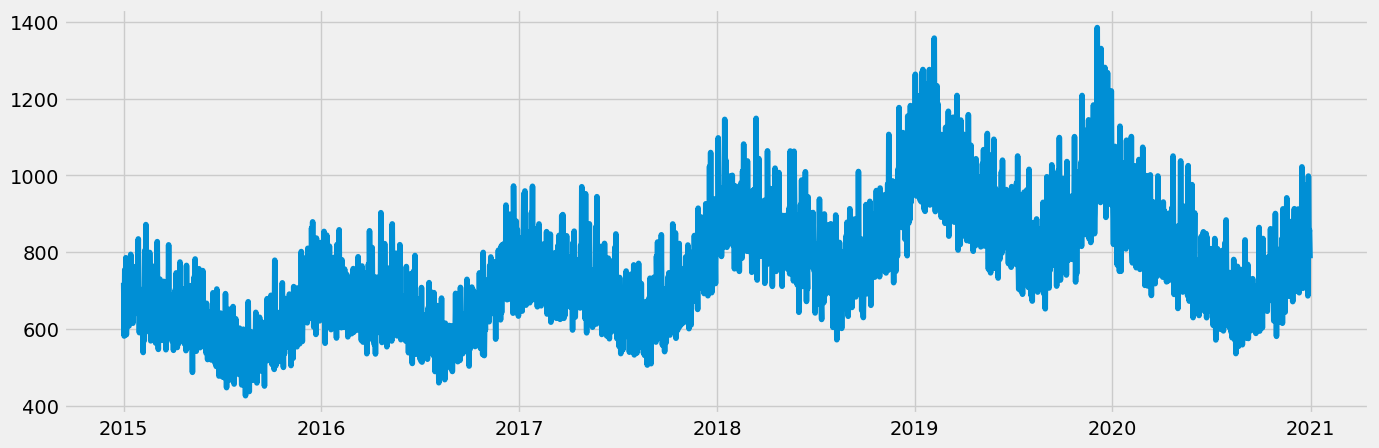

In [189]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

We can immediately see the seasonality pattern of the data where it rise and fall at the exact time every year, leading to the summer months the demand steadily decrease and peaks during the winter months. In general, demand has increased around 2018 and peaked in 2019, but from 2020 it shows a downward trend again. The reason for the sharpt decline in the demand of Airbnb's are probably due to the covid outbreak and lockdowns imposed on 2020.

In [131]:
# Checking for missing values 

df_sub.isnull().sum() 

Demand    0
dtype: int64

In [132]:
# Checking for duplicates

dups = df_sub.duplicated()
dups.sum()

0

### 3. Time-Series Analysis: Decomposition

In [133]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive', period=365)

In [134]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

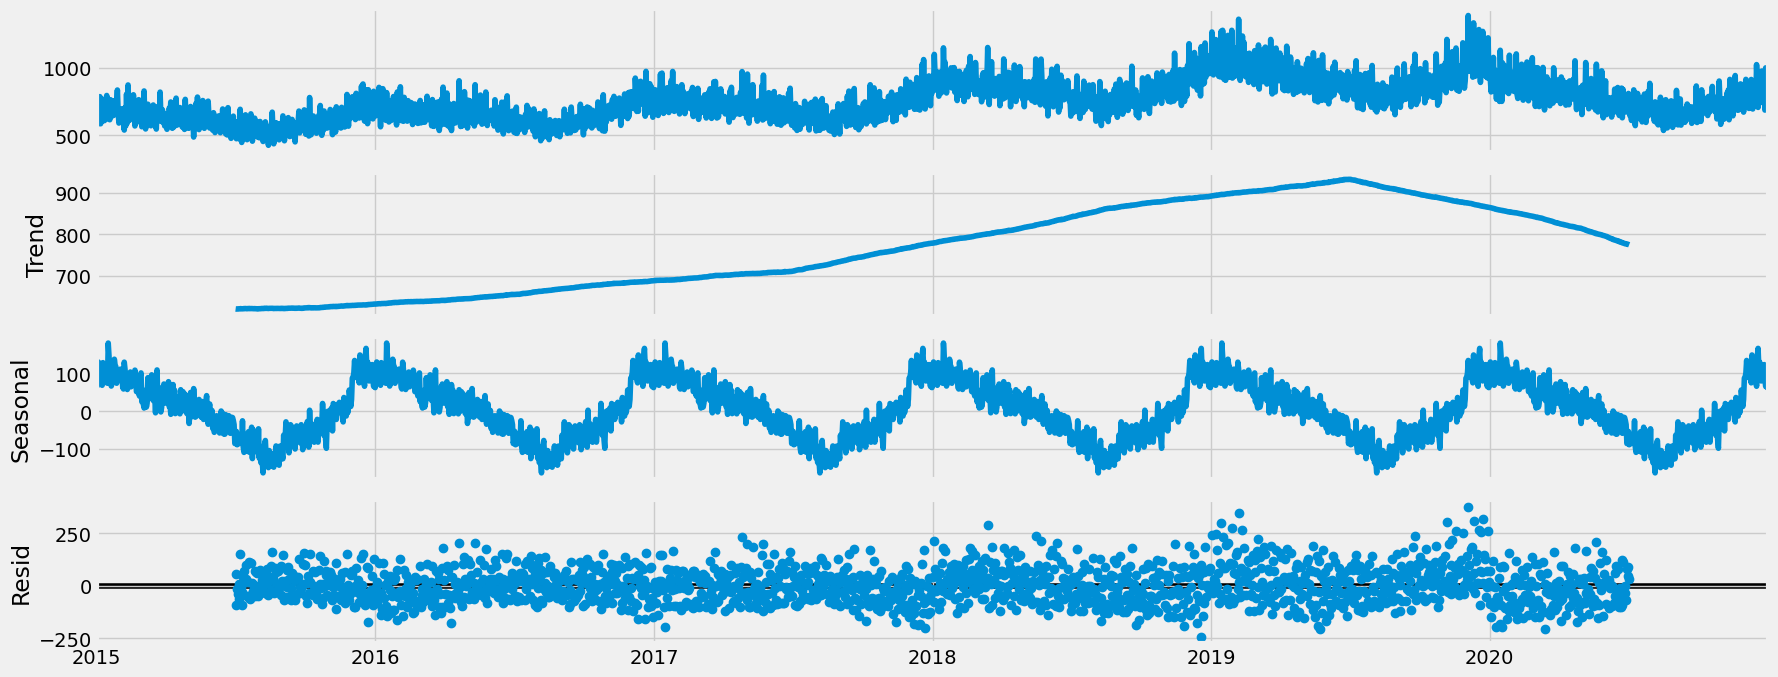

In [135]:
# Plotting the separate components

decomposition.plot()
plt.show()

The trend line shows the same pattern with the actual data because probably the data that doesn’t have much noise. The trend in the chart gradually increases in a linear fashion until around mid-2019 then overall trend starts to decrease.

Regarding seasonality, the fluctuations are represented by a curve that changes at a regular interval. 

For residual points, there isn’t much unexplained noise.

### 4. Testing for Stationarity

In [165]:
# Importing the adfuller() function from the model from statsmodels for the test

from statsmodels.tsa.stattools import adfuller 

# Defining the function

def dickey_fuller(timeseries): 
    # Performing the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Applying the test using the function on the time series
dickey_fuller(df_sub['Demand'])

Dickey-Fuller Stationarity test:
Test Statistic                   -1.807434
p-value                           0.376777
Number of Lags Used              23.000000
Number of Observations Used    2168.000000
Critical Value (1%)              -3.433370
Critical Value (5%)              -2.862874
Critical Value (10%)             -2.567480
dtype: float64


The p-value is 0.376777 and it is higher than any common significance level (0.01, 0.05, 0.10). This indicates that we cant reject the null hypothesis of non-stationarity.

Since the test statistic (-1.807434) is higher than all the critical values, it means the null hypothesis (that the time series has a unit root and is non-stationary) cannot be rejected.

This means is that there is a unit root in the data, and the data is non-stationary. 

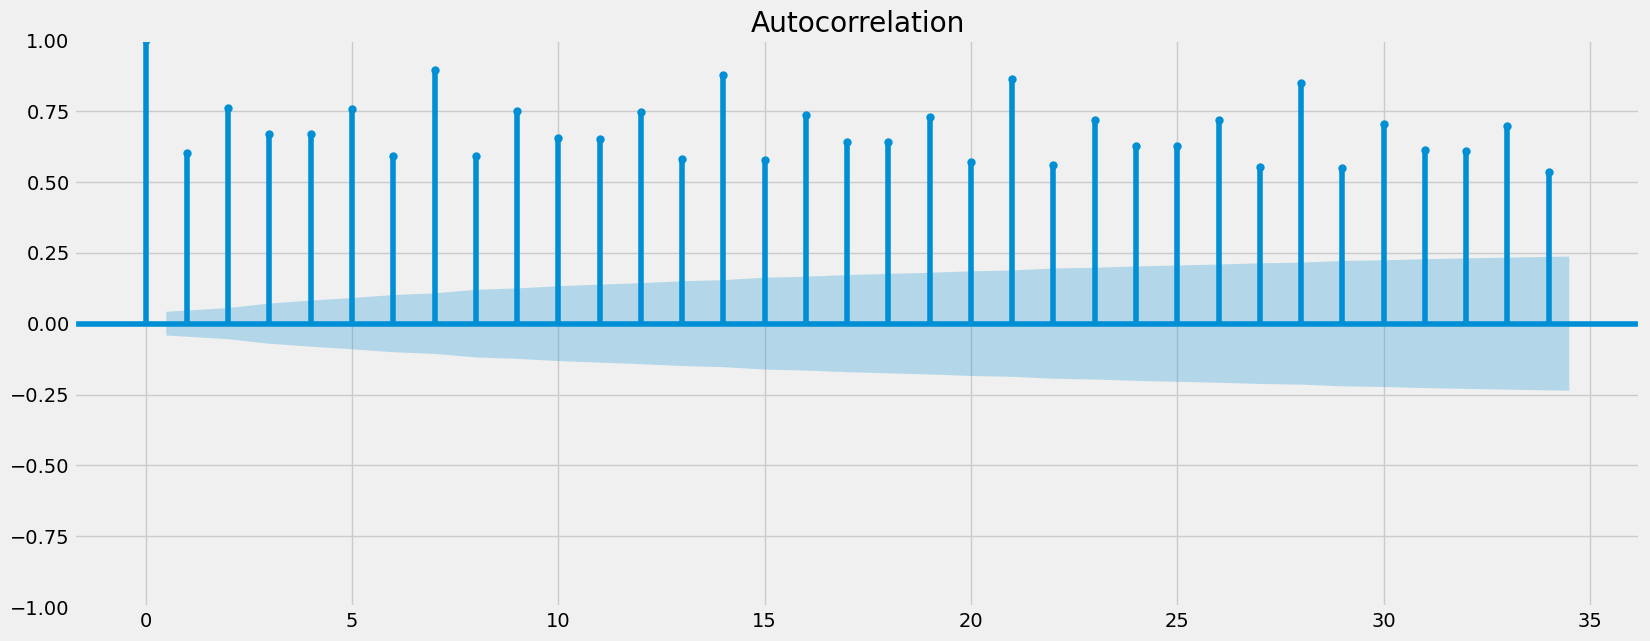

In [137]:
# Checking out a plot of autocorrelations

# Importing the autocorrelation and partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(df_sub)
plt.show()

All the lag lines go above the blue edge of the confidence interval and this means that all the lags are significantly correlated with each other and the data is non-stationary. This supports the result of the Dickey-Fuller test we conducted earlier.

### 5. Stationarizing Data

In [143]:
# Differencing the data

df_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [144]:
# Removing the missing values that came about as a result of the differencing 

df_diff.dropna(inplace = True) 

In [145]:
df_diff.head()

,Demand
datetime,
2015-01-02,-138.724112
2015-01-03,172.840266
2015-01-04,-131.864264
2015-01-05,163.120544
2015-01-06,-200.590336


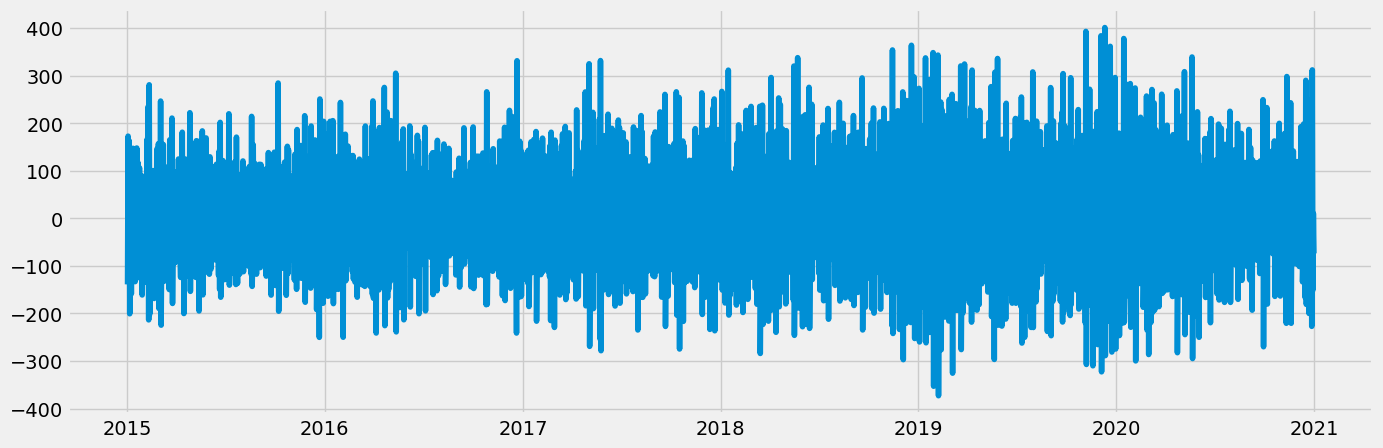

In [146]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [190]:
# Running the Dickey-Fuller test again to see how the new dataframe performs

dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.200048e+01
p-value                        3.355774e-22
Number of Lags Used            2.600000e+01
Number of Observations Used    2.164000e+03
Critical Value (1%)           -3.433375e+00
Critical Value (5%)           -2.862877e+00
Critical Value (10%)          -2.567482e+00
dtype: float64


The p-value is -1.200048 and it is lower than any significance level (0.01, 0.05, 0.10). This indicates that we still can't reject the null hypothesis of non-stationarity.

Since the test statistic (-1.200048) is higher than all the critical values, it means the null hypothesis (that the time series has a unit root and is non-stationary) cannot be rejected.

This means is that there is still a unit root in the data, and the data is non-stationary.

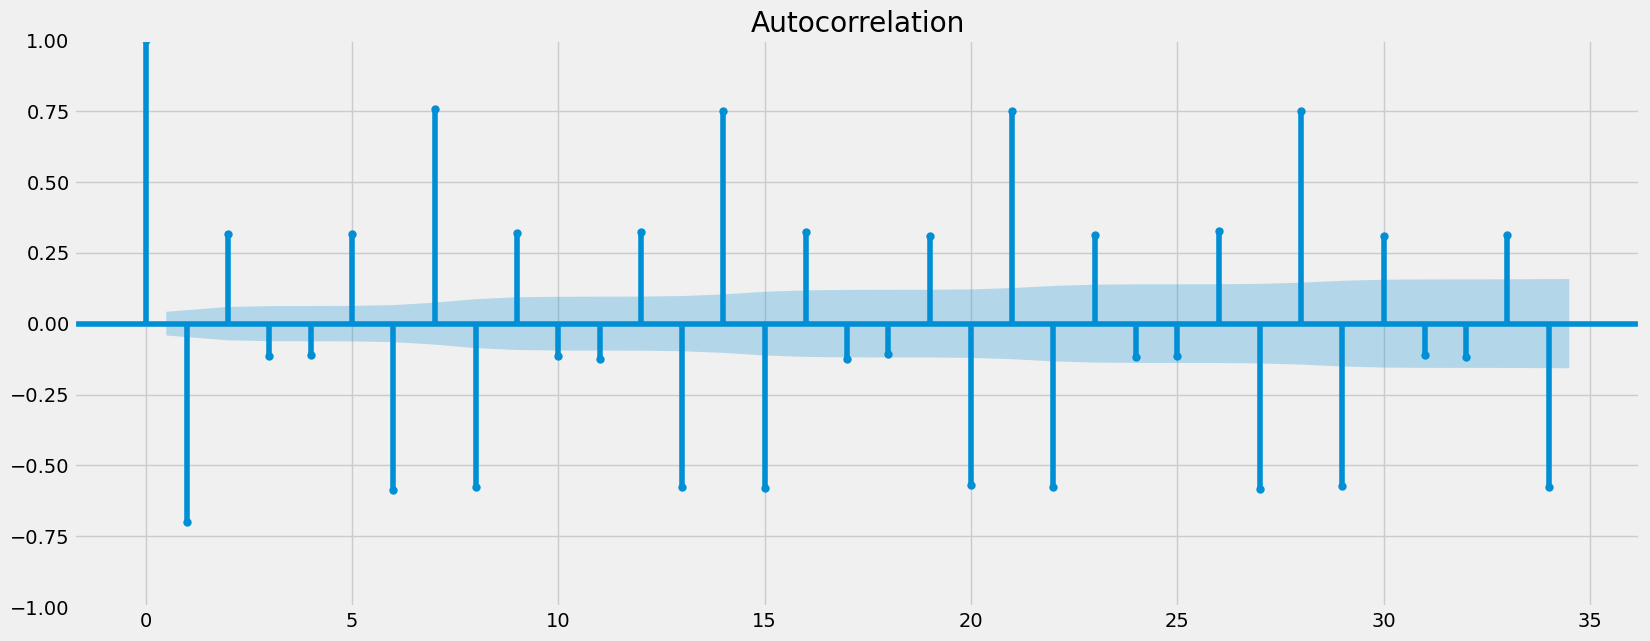

In [183]:
plot_acf(df_diff)
plt.show()

Autocorrelation plot has improved a tiny bit but it’s far from perfect considering that we failed to stationarize the data. 